# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

In [8]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

## Handling IID data

# Handling non-iid data

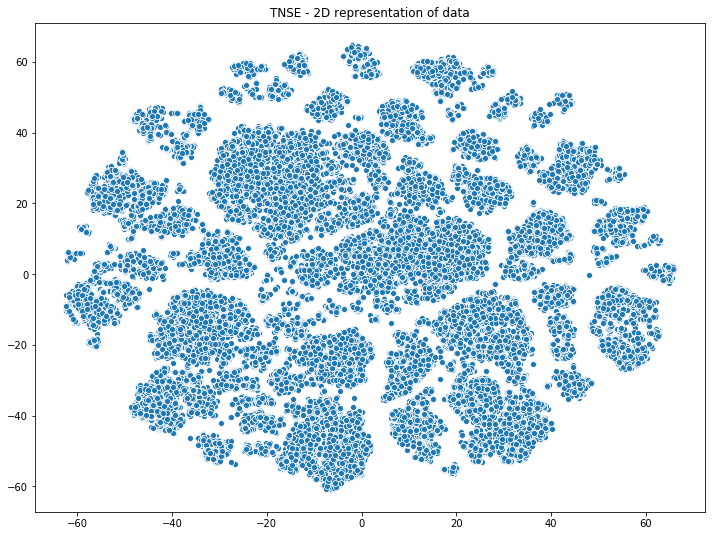

In [124]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tnse(data)
pickle_saver(embedded_data, filename + "-tsne")

There is 10 devices.
Number of points on device 0 : 4069
Number of points on device 1 : 15632
Number of points on device 2 : 1417
Number of points on device 3 : 1655
Number of points on device 4 : 4127
Number of points on device 5 : 2263
Number of points on device 6 : 7525
Number of points on device 7 : 3038
Number of points on device 8 : 1848
Number of points on device 9 : 8426
CPU times: user 45 s, sys: 383 ms, total: 45.4 s
Wall time: 11.5 s


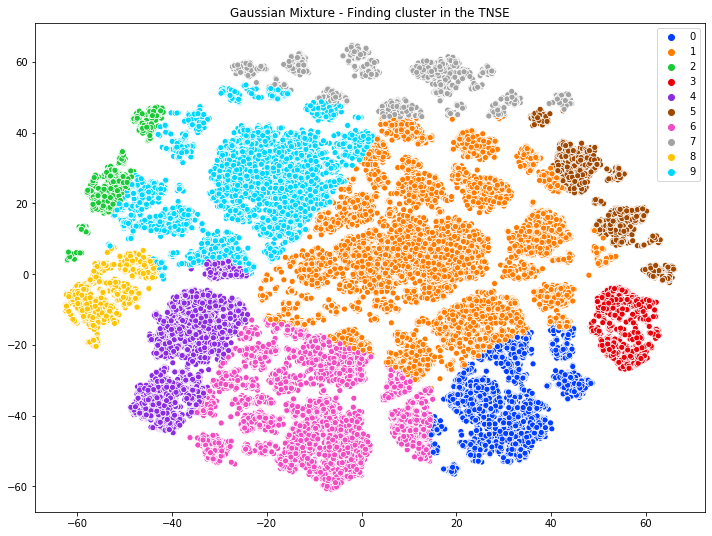

In [9]:
%%time
nb_cluster = 10
embedded_data = pickle_loader(filename + "-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

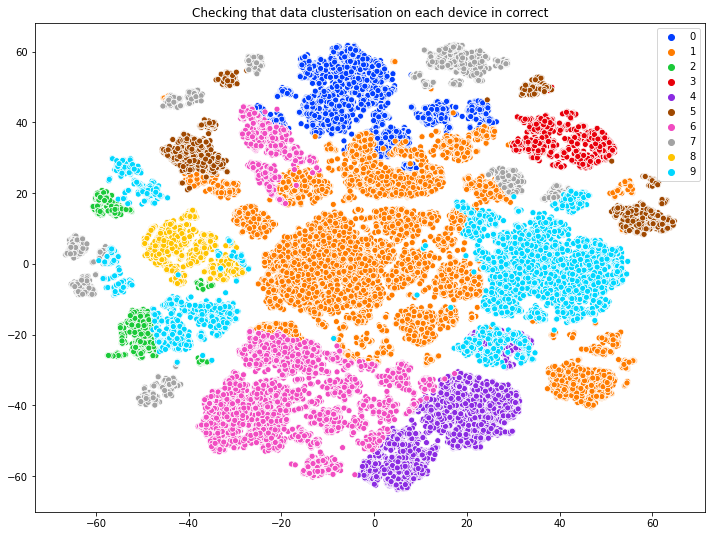

In [126]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [10]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.5863848611452446
ratio of state 1 on this device:  0.5730552712384852
ratio of state 1 on this device:  0.5151729004940014
ratio of state 1 on this device:  0.48338368580060426
ratio of state 1 on this device:  0.3792100799612309
ratio of state 1 on this device:  0.4882898806893504
ratio of state 1 on this device:  0.5924252491694352
ratio of state 1 on this device:  0.2662936142198815
ratio of state 1 on this device:  0.43235930735930733
ratio of state 1 on this device:  0.3858295751246143


In [11]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_cluster,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.set_data(X,Y)
obj_min_by_N_descent.run()
obj_min_by_N[nb_cluster] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-noniid-obj_min")

Large dimension...
   it    |   obj   
    4000 | 5.4153e-01
    8000 | 5.4152e-01
   12000 | 5.4152e-01
   16000 | 5.4151e-01
Gradient Descent: execution time=208.509 seconds
Final loss :  0.5415120495244439

CPU times: user 13min 47s, sys: 4.25 s, total: 13min 52s
Wall time: 3min 28s


### Batch size $= 1$

In [15]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = LogisticModel(), 
                                               use_averaging=False, stochastic=True, batch_size=1, nb_epoch=50)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-10")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...
Large dimension...


  0%|          | 0/5 [1:01:20<?, ?it/s]


ValueError: slice step cannot be zero

<Figure size 576x504 with 0 Axes>

## Without averaging

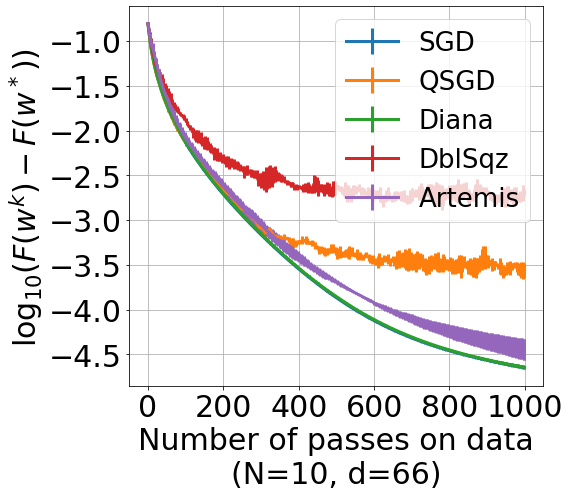

In [13]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-10")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

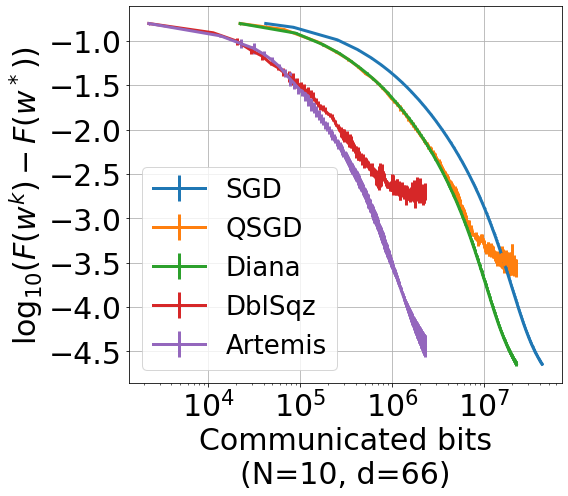

In [14]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

### Batch size $= 1000$

In [46]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = LogisticModel(), 
                                               use_averaging=False, stochastic=True, batch_size=100, nb_epoch=50)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-1000")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...
Large dimension...


 20%|██        | 1/5 [02:21<09:27, 141.82s/it]

QSGD
Large dimension...
Large dimension...
Large dimension...


 40%|████      | 2/5 [05:13<07:32, 150.86s/it]

Diana
Large dimension...
Large dimension...
Large dimension...


 60%|██████    | 3/5 [08:09<05:16, 158.20s/it]

DblSqz
Large dimension...
Large dimension...
Large dimension...


 80%|████████  | 4/5 [11:07<02:44, 164.40s/it]

Artemis
Large dimension...
Large dimension...
Large dimension...


100%|██████████| 5/5 [14:06<00:00, 169.29s/it]

CPU times: user 21min 31s, sys: 4.94 s, total: 21min 36s
Wall time: 14min 6s


#### Without averaging

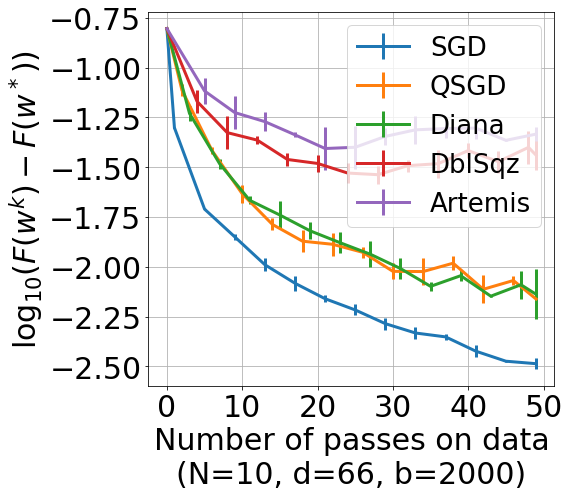

In [47]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-1000")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=2000,
               all_error=res.get_std(obj)) 

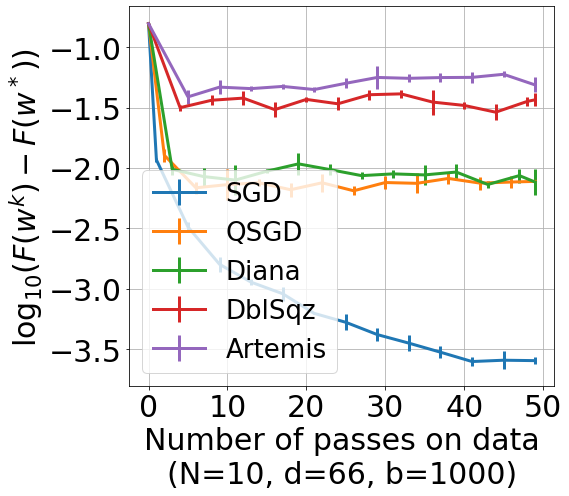

In [44]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent-1000")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=1000,
               all_error=res.get_std(obj)) 

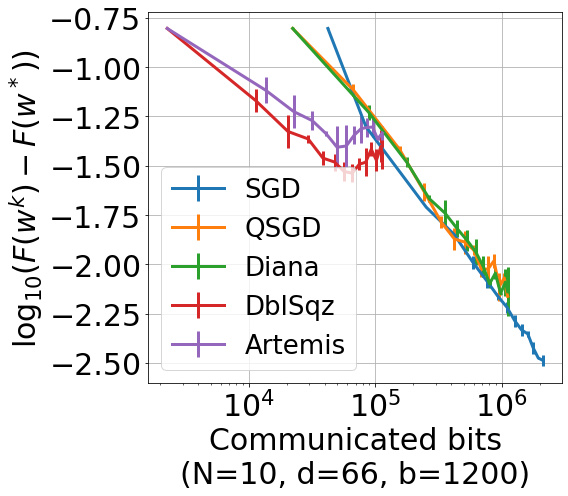

In [48]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=1200,
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 